<a href="https://colab.research.google.com/github/KT2001/Omdena_Algeria_Project_OneShotLearning/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the Dependencies

Here we are using, a smaller dataset created using Tomato Curl leaf virus (as positive and anchor images) and Tomato healthy images (as negative images).

Link to the smaller dataset: https://drive.google.com/file/d/1WT_1MLG8Dd0CkfWtAL3rEP9BMoetwmdq/view?usp=sharing

In [1]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# visulizations
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import random
import time
import cv2
import glob
from scipy import misc
import pathlib

We have to unzip the dummy dataset.

In [ ]:
!unzip /content/drive/MyDrive/PlantVillage/One_shot_dataset.zip

In [3]:
num_classes = {}
sum = 0
dir = os.listdir('/content/One_shot_dataset')
print(f"Number of classes: {len(dir)} \n")
for filenames in dir:
  num_classes[filenames] = len(os.listdir(f"{'/content/One_shot_dataset'}/{filenames}"))
  sum = num_classes[filenames]+sum
  print(f"{filenames}: {(num_classes[filenames])}")
print(f"\nTotal number of images: {sum}")

Number of classes: 3 

ANC_IMAGES: 1000
NEG_IMAGES (Tomato_healthy): 1000
POS_IMAGES (Tomato_yellow_curl_virus): 1000

Total number of images: 3000


In [4]:
plants=list(num_classes.keys())
values=list(num_classes.values())

<Figure size 2160x720 with 0 Axes>

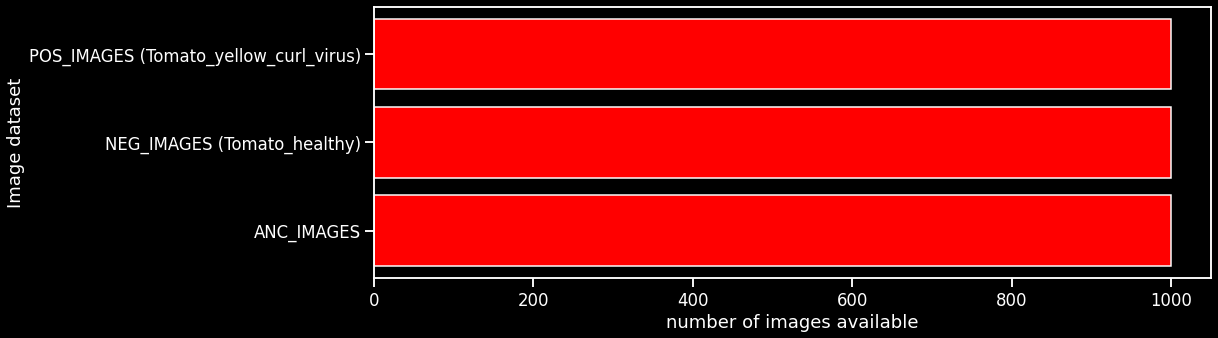

<Figure size 2160x720 with 0 Axes>

In [5]:
plt.figure(figsize=(15, 5))
plt.xlabel("number of images available")
plt.ylabel("Image dataset")
plt.barh(plants, values, color = 'Red', capsize = 10)
plt.figure(figsize=(30, 10))

In [6]:
# Creating path variables
Pos_path = os.path.join('/content/One_shot_dataset/POS_IMAGES(Tomato_yellow_curl_virus)')
Neg_path = os.path.join('/content/One_shot_dataset/NEG_IMAGES(Tomato_healthy)')
Anc_path = os.path.join('/content/One_shot_dataset/ANC_IMAGES')

In [7]:
# This step would be optional step as we will make some changes with the final dataset but this might not be necessary.
def renamer(path):
  i = 0
  for filename in os.listdir(path):
      my_dest ="image" + str(i) + ".jpg"
      my_source =path +'/'+ filename
      my_dest =path +'/'+ my_dest
      # rename() function will
      # rename all the files
      os.rename(my_source, my_dest)
      i += 1

In [8]:
renamer(Anc_path)
renamer(Pos_path)
renamer(Neg_path)

In [9]:
anchor = tf.data.Dataset.list_files(Anc_path+'/*.jpg').take(1000)
positive = tf.data.Dataset.list_files(Pos_path+'/*.jpg').take(1000)
negative = tf.data.Dataset.list_files(Neg_path+'/*.jpg').take(1000)

the size of the image in the original paper was 105x105x1 but considering we have 3 colour channels here we will have 105x105x3.

In [11]:
# the preprocessing layer
def preprocess(path):
  # read an image from file path
  byte_img = tf.io.read_file(path)
  # Load the image
  img = tf.io.decode_jpeg(byte_img)

  # preprocess steps - resize image to be 105x105x3
  img = tf.image.resize(img, (105, 105))
  # scaling the image between 0, 1
  img = img/255.0

  return img

### Creating labelled dataset

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# this is our combined data
data = positives.concatenate(negatives)

In [14]:
# to preprocess both layers at the same time
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
# building a dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024, seed = 42)

### Splitting the data into train and test data

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

We don't need to split it into a validation set we can do that after the model is built while we are validating it.